Since the MAGs were selected from all treatments, they were not classified into specific groups. Therefore, to assess the effect of treatments on MAG abundances, clustering was performed based on co-abundance patterns.

In [6]:
import pandas as pd
from scipy.stats import kruskal
from statsmodels.stats.multitest import multipletests

In [7]:
#Import dataset
relat_abund=pd.read_csv('relative_abundances.tsv', sep="\t")
print(relat_abund.head())

   mag              bin_code        tax_code treatment sample  \
0  C_1           C_27077.fna     UBA5704 (a)         C     C1   
1  C_2  C_maxbin_C.028.fasta          HGW-15         C     C1   
2  C_3    C_metabat_C.121.fa     ZC4RG35 (a)         C     C1   
3  C_4    C_metabat_C.124.fa  Micropepsaceae         C     C1   
4  C_5    C_metabat_C.125.fa        SZUA-232         C     C1   

   relative_abundance  
0            0.023611  
1            0.017551  
2            0.030736  
3            0.013161  
4            0.051670  


First, a Kruskal-Wallis analysis was conducted using the relative abundances of the mappings of unassembled reads onto the MAGs to identify significant differences between treatments. To control for multiple comparisons, p-values were adjusted using the Bonferroni correction.

In [ ]:
# Store results
p_values = []
mags = []

# Loop over each mag and perform the Kruskal-Wallis test
for mag in relat_abund['mag'].unique():
    # Subset data for the current mag
    mag_data = relat_abund[relat_abund['mag'] == mag]
    
    # Group data by treatment
    groups = [mag_data[mag_data['treatment'] == treatment]['relative_abundance'] for treatment in mag_data['treatment'].unique()]
    
    # Perform Kruskal-Wallis test
    stat, p_value = kruskal(*groups)
    p_values.append(p_value)
    mags.append(mag)

# Adjust p-values for multiple testing using Benjamini-Hochberg
_, corrected_p_values, _, _ = multipletests(p_values, method='fdr_bh')

# Create a DataFrame with the results
results_df = pd.DataFrame({'mag': mags, 'p-value': p_values, 'corrected p-value': corrected_p_values})
significant_mags = results_df[results_df['corrected p-value'] < 0.05]

# Display significant MAGs
print(significant_mags)

     mag   p-value  corrected p-value
0    C_1  0.012620           0.020695
1    C_2  0.032386           0.039014
2    C_3  0.022307           0.028960
3    C_4  0.008254           0.020361
4    C_5  0.032687           0.039014
..   ...       ...                ...
69   P_9  0.042272           0.048125
70  P_10  0.011032           0.020695
71  P_11  0.006928           0.020361
72  PW_1  0.023161           0.029550
73  PW_2  0.036847           0.042604

[66 rows x 3 columns]


Then, Dunn's test was used to determine specifically between which treatments these differences were found.

In [1]:
import scikit_posthocs as sp

In [ ]:

for mag in significant_mags['mag']:
    # Subset data for the current MAG
    mag_data = relat_abund[relat_abund['mag'] == mag]
    
    # Perform Dunn's test for pairwise comparisons between treatments
    dunn_results = sp.posthoc_dunn(mag_data, val_col='relative_abundance', group_col='treatment', p_adjust='fdr_bh')
    
    # Display results
    print(f"Dunn's test results for {mag}:\n", dunn_results)

Dunn's test results for C_1:
            C        CW         L        LW         P        PW
C   1.000000  0.813954  0.161284  0.196506  0.342749  0.810225
CW  0.813954  1.000000  0.196506  0.243722  0.243722  0.939044
L   0.161284  0.196506  1.000000  0.810225  0.015120  0.196506
LW  0.196506  0.243722  0.810225  1.000000  0.027462  0.253003
P   0.342749  0.243722  0.015120  0.027462  1.000000  0.243722
PW  0.810225  0.939044  0.196506  0.253003  0.243722  1.000000
Dunn's test results for C_2:
            C        CW         L        LW         P        PW
C   1.000000  0.939044  0.072005  0.939044  0.168434  0.877743
CW  0.939044  1.000000  0.072005  0.939044  0.166144  0.877743
L   0.072005  0.072005  1.000000  0.072005  0.818829  0.146053
LW  0.939044  0.939044  0.072005  1.000000  0.166144  0.877743
P   0.168434  0.166144  0.818829  0.166144  1.000000  0.316254
PW  0.877743  0.877743  0.146053  0.877743  0.316254  1.000000
Dunn's test results for C_3:
            C        CW      

In [ ]:
%%capture #many graphs

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

plt.ioff()  # Turn off interactive mode

for mag in significant_mags['mag']:
    # Subset data for the current MAG
    mag_data = relat_abund[relat_abund['mag'] == mag]
    
    # Perform Dunn's test for pairwise comparisons between treatments
    dunn_results = sp.posthoc_dunn(mag_data, val_col='relative_abundance', group_col='treatment', p_adjust='fdr_bh')
    
    # Create a mask for p-values >= 0.05 and the lower triangle of the matrix
    mask = np.tril(np.ones_like(dunn_results, dtype=bool)) | (dunn_results >= 0.05)
    
    # Create a custom colormap where non-significant values are white
    cmap = sns.color_palette(["white", "red"])
    
    # Plot the heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(dunn_results, mask=mask, annot=True, cmap=cmap, cbar=False, linewidths=0.5)
    
    plt.title(f"Dunn's Test Results for {mag}")
    plt.show()


Next, a hierarchical clustering of the MAGs was performed based on these significant differences, using Ward's method, which minimizes variance within each formed group. Finally, a dendrogram was generated to visualize the clustering of MAGs and identify the main co-abundance groups. This new categorization was used for further analyses involving the MAGs.

In [17]:
import os

import numpy as np
import matplotlib.cm as cm
from scipy.stats import hypergeom, chi2_contingency
import upsetplot as up
import glob

In [ ]:
#import new table
#This new table was made manually in excel based on Dunn's Test results

differences = pd.read_csv("sign_differences.tsv", sep="\t")
print(differences)

                          mag  \
0                    70-9 (a)   
1                    70-9 (b)   
2        Promineofilaceae (a)   
3                    JABDQX01   
4                 UBA6522 (d)   
..                        ...   
69          Streptomycetaceae   
70              Bacillaceae_C   
71  Sporolactobacillaceae (a)   
72            Domibacillaceae   
73           Paenibacillaceae   

                                          differences  
0                                      C_CW_1, C_PW_2  
1                                                 NaN  
2                                             LW_PW_2  
3                            CW_L_1, CW_LW_1, LW_PW_2  
4                                      CW_L_1, L_PW_2  
..                                                ...  
69                                      CW_L_2, L_P_1  
70                       C_L_2, CW_L_2, L_P_1, L_PW_1  
71  C_L_2, C_LW_2, CW_LW_2, CW_L_2, L_P_1, L_PW_1,...  
72  C_L_2, C_LW_2, CW_LW_2, CW_L_2, L_P_1, 

In [19]:
# Split the 'differences' column by comma and expand the rows
df_split = differences.assign(differences=differences['differences'].str.split(', ')).explode('differences')

# Display the updated DataFrame
print(df_split)

                     mag differences
0               70-9 (a)      C_CW_1
0               70-9 (a)      C_PW_2
1               70-9 (b)         NaN
2   Promineofilaceae (a)     LW_PW_2
3               JABDQX01      CW_L_1
..                   ...         ...
73      Paenibacillaceae      CW_L_2
73      Paenibacillaceae       L_P_1
73      Paenibacillaceae      L_PW_1
73      Paenibacillaceae     LW_PW_1
73      Paenibacillaceae      LW_P_1

[172 rows x 2 columns]


In [20]:
# Create a pivot table to form a binary matrix
binary_matrix = pd.crosstab(df_split['mag'], df_split['differences'])

# Display the binary matrix
print(binary_matrix)

differences                CW_LW_1  CW_LW_2  CW_L_1  CW_L_2  CW_P_1  CW_P_2  \
mag                                                                           
70-9 (a)                         0        0       0       0       0       0   
Alkalibacteraceae                0        1       0       0       0       0   
Bacillaceae_C                    0        0       0       1       0       0   
Balneolaceae (a)                 0        0       0       0       0       1   
Balneolaceae (b)                 0        1       0       0       0       0   
CECT-8803                        0        0       0       1       0       1   
Cellulomonadaceae                0        0       0       1       0       0   
Cyclobacteriaceae                0        1       0       1       0       0   
Desulfobacterales                0        0       0       0       0       0   
Domibacillaceae                  0        1       0       1       0       0   
E44-bin32 (b)                    1        0       1 

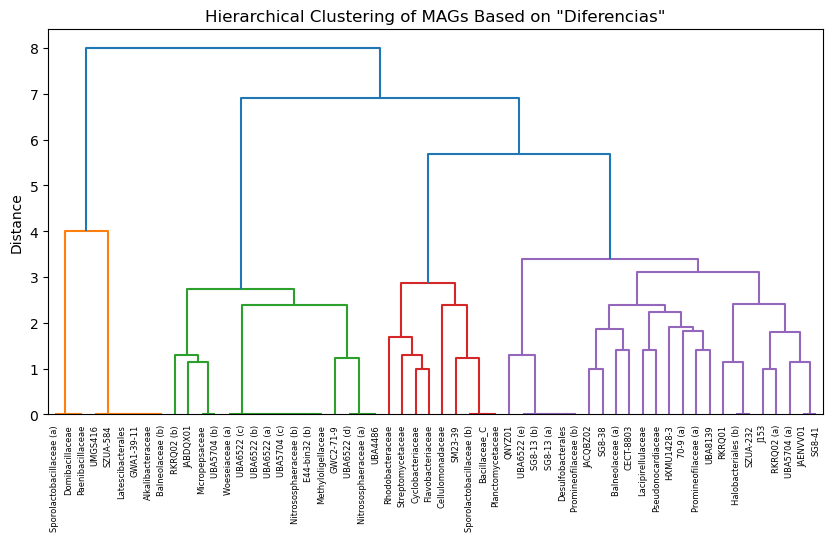

In [24]:
from scipy.cluster.hierarchy import linkage, dendrogram

# Perform hierarchical clustering
linkage_matrix = linkage(binary_matrix, method='ward')

# Plot the dendrogram
plt.figure(figsize=(10, 5))
dendrogram(linkage_matrix, labels=binary_matrix.index)
plt.title('Hierarchical Clustering of MAGs Based on "Diferencias"')
plt.ylabel('Distance')
plt.show()

In [26]:
order =  ['Sporolactobacillaceae (a)', 'Domibacillaceae', 'Paenibacillaceae', 'UMGS416', 'SZUA-584', 'Latescibacterales', 
           'GWA1-39-11', 'Alkalibacteraceae', 'Balneolaceae (b)', 'RKRQ02 (b)', 'JABDQX01', 'Micropepsaceae', 'UBA5704 (b)', 
           'Woeseiaceae (a)', 'UBA6522 (c)', 'UBA6522 (b)', 'UBA6522 (a)', 'UBA5704 (c)', 'Nitrososphaeraceae (b)', 'E44-bin32 (b)', 
           'Methyloligellaceae', 'GWC2-71-9', 'UBA6522 (d)', 'Nitrososphaeraceae (a)', 'UBA4486', 'Rhodobacteraceae', 'Streptomycetaceae', 
           'Cyclobacteriaceae', 'Flavobacteriaceae', 'Cellulomonadaceae', 'SM23-39', 'Sporolactobacillaceae (b)', 'Bacillaceae_C',
           'Planctomycetaceae', 'QNYZ01', 'UBA6522 (e)', 'SG8-13 (b)', 'SG8-13 (a)', 'Desulfobacterales', 'Promineofilaceae (b)', 
           'JACQBZ02', 'SG8-38', 'Balneolaceae (a)', 'CECT-8803', 'Lacipirellulaceae', 'Pseudonocardiaceae', 'HXMU1428-3', '70-9 (a)', 
           'Promineofilaceae (a)', 'UBA8139', 'RKRQ01', 'Halobacteriales (b)', 'SZUA-232', 'J153', 'RKRQ02 (a)', 'UBA5704 (a)', 'JAENVV01',  
           'SG8-41', "Halobacteriales (a)", "Nitriliruptoraceae", "HGW-15", "ZC4RG35 (a)", "ZC4RG35 (b)", "E44-bin32 (a)", "Hyphomicrobiaceae",
           "Woeseiaceae (b)", "70-9 (b)", "UBA11606", "SZUA-229", "RKSH01", "JAFGWO01", "Jiangellales", "Anaerolineaceae", "DSSB01" ]

In [27]:
relat_abund_matrix=pd.read_csv('relative_abundances_matrix.tsv', sep="\t")

In [28]:
print(relat_abund_matrix.head())

              MAG        L1        L2        L3       LW1       LW2       LW3  \
0     UBA5704 (a)  0.010176  0.007946  0.009739  0.009508  0.011494  0.012538   
1          HGW-15  0.008407  0.007143  0.009152  0.014858  0.020393  0.015126   
2     ZC4RG35 (a)  0.025695  0.021512  0.024399  0.014376  0.013566  0.020554   
3  Micropepsaceae  0.007900  0.007598  0.009477  0.004968  0.005192  0.005143   
4        SZUA-232  0.038197  0.037041  0.038272  0.017993  0.027007  0.031507   

         C1        C2        C3        P1        P2        P3       PW1  \
0  0.023611  0.021729  0.021871  0.026040  0.028003  0.029527  0.014324   
1  0.017551  0.013071  0.017067  0.009681  0.009629  0.011139  0.012007   
2  0.030736  0.026828  0.030382  0.031315  0.029169  0.033269  0.017303   
3  0.013161  0.015697  0.012917  0.012806  0.012180  0.012663  0.012501   
4  0.051670  0.053576  0.055289  0.046690  0.034613  0.044034  0.033332   

        CW1       CW2       CW3       PW2       PW3  
0  0.019

In [29]:
relat_abund_matrix.set_index('MAG', inplace=True)

In [30]:
# Reorder the DataFrame based on the specified taxon order
relat_abund_matrix = relat_abund_matrix.reindex(order)

# Check the updated DataFrame
print(relat_abund_matrix.head())

                                 L1        L2        L3       LW1       LW2  \
MAG                                                                           
Sporolactobacillaceae (a)  0.024131  0.030787  0.026412  0.020603  0.028460   
Domibacillaceae            0.033753  0.042930  0.035431  0.036136  0.038355   
Paenibacillaceae           0.056795  0.075797  0.062129  0.062733  0.076868   
UMGS416                    0.000000  0.000000  0.000000  0.003019  0.012519   
SZUA-584                   0.000000  0.000000  0.000000  0.003441  0.013361   

                                LW3   C1   C2   C3   P1   P2   P3  PW1  CW1  \
MAG                                                                           
Sporolactobacillaceae (a)  0.026466  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
Domibacillaceae            0.039509  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
Paenibacillaceae           0.066289  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
UMGS416                    0.013227  0.0  0.0  0.0 

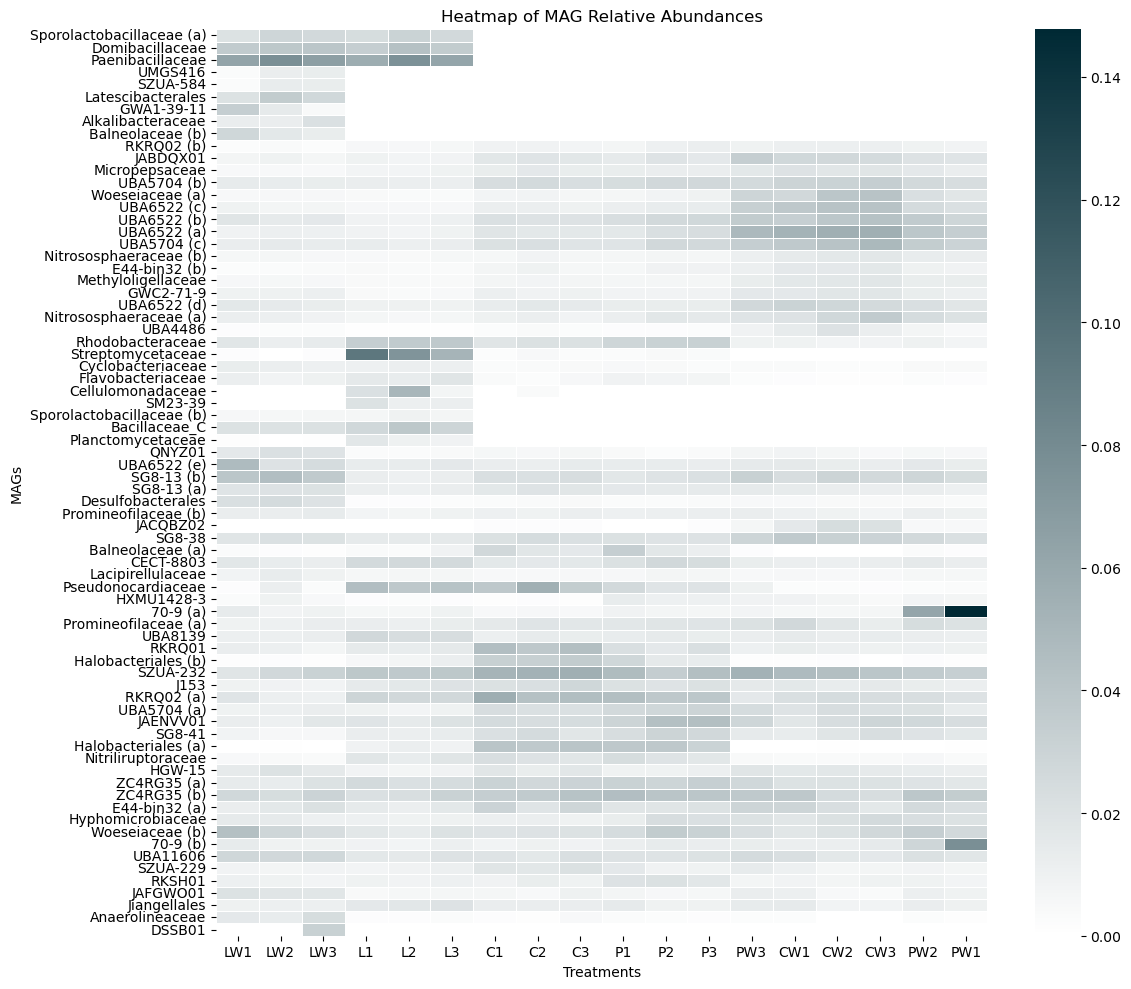

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

# Column order
desired_order = ['LW1', 'LW2', 'LW3', 'L1', "L2", "L3", "C1", "C2", "C3", "P1", "P2", "P3", "PW3", "CW1", "CW2", "CW3", "PW2", "PW1"]  # Replace with your actual column names

# Reorder the columns in the DataFrame
relat_abund_matrix = relat_abund_matrix[desired_order]

# Create a custom color map
custom_cmap = LinearSegmentedColormap.from_list('custom_cmap', ['white', '#002934'])

# Create the heatmap
plt.figure(figsize=(12, 10))  # Adjust the size as needed to fit all labels
sns.heatmap(relat_abund_matrix, cmap=custom_cmap, linewidths=0.5, yticklabels=True)

# Customize the heatmap
plt.title('Heatmap of MAG Relative Abundances')
plt.xlabel('Treatments')
plt.ylabel('MAGs')

# Ensure that all labels fit
plt.tight_layout()

# Show the plot
plt.show()